# Network Validation

purpose: 
to annotate network with validation from:
- gwas catalog
- gprofiler family
to quantify the enrichment of gwas catalog for GWAS catalog traits

Figures Generated:

Tables Generated:
- supplemental table 5

TO DO:
- merge in genebass phewas into dataframe
- update meta data to make rare seed genes alcohol full table

- STOPPED AT FUMA GENE2FUNC

# set-up

## import packages

In [4]:
from ndex2.nice_cx_network import NiceCXNetwork
import ndex2.client as nc
import ndex2
import networkx as nx
import pandas as pd
import numpy as np
import os
from netcoloc import netprop_zscore
from netcoloc import netprop
from netcoloc import network_colocalization
from scipy.stats import hypergeom
#import upsetplot
from upsetplot import plot as upplot
from upsetplot import from_contents
from upsetplot import UpSet

import matplotlib.pyplot as plt
from rca_functions import *
import sys

In [8]:
os.chdir('../')

In [10]:
#boolean determining whether figures will be saved
save_fig=False
#boolean to determine if tables will be saved
save_file=False

In [11]:
#create a file called environ_ndex_meta.py where you save variables 'ndex_user' and 'ndex_password'
#otherwise will prompt you to define those within the notebooks
if os.path.isfile('../environ_ndex_meta.py'):
    print ('NDEx credentials imported from meta file')
    sys.path.insert(1, '../')
    from environ_ndex_meta import *
    sys.path.pop(1)
else:
    # Prompt the user for a username
    ndex_user = input("Enter your NDEx username: ")
    # Prompt the user for a password
    ndex_password = input("Enter your NDEx password: ")

NDEx credentials imported from meta file


# import pcnet

In [5]:
interactome=import_interactome(interactome_name='pcnet_v14')

pcnet_v14
number of nodes:
18630

number of edges:
2687393


# read in common and rare meta data

In [93]:
rare_datasets=pd.read_csv('rare_datasets_prepub.csv')
common_datasets=pd.read_csv('common_datasets_prepub.csv')

# choose network to analyze and import colocalized network

In [18]:
#set which network you're annotating- aligns to the UUID dictionary in rca_functions
#presume youre running analysis for ACN- so imports the unannotated version of the ACN network
analysis_dataset='ACN_unannot'

In [8]:
UUIDs

{'pcnet_v14': 'c3554b4e-8c81-11ed-a157-005056ae23aa',
 'pcnet_v13': '4de852d9-9908-11e9-bcaf-0ac135e8bacf',
 'string': '98ba6a19-586e-11e7-8f50-0ac135e8bacf',
 'humanNet_v3_FN': '40913318-3a9c-11ed-ac45-0ac135e8bacf',
 'ACN': '29b2d215-07fd-11ef-9621-005056ae23aa',
 'ACN_unannot': 'f81a3f67-4215-11ee-aa50-005056ae23aa',
 'ACN_strin': '48de252c-3d50-11ee-aa50-005056ae23aa'}

In [19]:
#read in network chosen above
network = ndex2.create_nice_cx_from_server(server='public.ndexbio.org',username='bsleger',password='Pyjgor-3sarwe-puvfyb', uuid=UUIDs[analysis_dataset])
nodes=list(nx.get_node_attributes(network, 'n').values())

In [25]:
#import gene families and HGNC approved names
families=pd.read_csv('input_files/ACN_family.csv')

# import rare and common variant seed genes

In [90]:
row_rare=0 #row of rare_datasets that contains metadata for rare variant files
row_common=0 #row of common_datasets that contains metadata for rare variant files

In [94]:
#import ACN rare variant seed genes full table
print('importing '+rare_datasets['label'][row_rare]+ " seed genes.")
seed_rare=pd.read_csv('input_files/rare_variant_genebass/alcohol_intake/alcohol_intake_FDR_25_full_table.csv')
seed_rare=list(seed_rare[rare_datasets['seed_gene_name'][row_rare]])

importing alcoholintake_FDR_25 seed genes.


In [95]:
#import ACN common variant seed genes
print('importing '+common_datasets['label'][row_common]+ " seed genes.")
seed_common=import_seedgenes(path=common_datasets['seed_path'][row_common],
                pcol=common_datasets['seed_p'][row_common],
                gene_col=common_datasets['seed_gene_name'][row_common],
                delim=common_datasets['delim'][row_common],
                cutoff=common_datasets['cutoff'][row_common])

importing GSCAN_DPW_magma seed genes.
       GENE  CHR     START      STOP  NSNPS  NPARAM       N   ZSTAT  \
202   79814    1  15561699  15595110    199      19  628831  4.9260   
203   84301    1  15607458  15671057    215      18  618929  5.5125   
204    6248    1  15649869  15671722     63      10  625701  5.6159   
205   23207    1  15674267  15744769    299      32  623320  6.6035   
465  127550    1  33296766  33331098    137      27  614472  4.6316   

                P GENE_NAME  
202  4.195900e-07     AGMAT  
203  1.769100e-08      DDI2  
204  9.774400e-09    RSC1A1  
205  2.008100e-11   PLEKHM2  
465  1.814100e-06   A3GALT2  


# query gwas catalog for network genes with alcohol traits

## import and format gwas catalog

In [12]:
cat=format_catalog(pd.read_csv('input_files/gwas_catalog_v1.0.2-associations_e111_r2024-04-22.tsv.gz',compression='gzip',sep='\t',low_memory=False))

In [17]:
format_subset_cat(subset_catalog(cat, 'alcohol'),nodes)

NameError: name 'format_subset_cat' is not defined

In [16]:
#subset the gwas catalog for traits of interest
cat_traits={
    'alc': subset_catalog(cat, 'alcohol'),
    'smok': subset_catalog(cat, 'nicotine'),
    'SUD': subset_catalog(cat, 'SUD'),
    'neuropsych': subset_catalog(cat, 'neuropsych')
}
if save_file:
   for k in cat_traits.keys():
       with open('calculated_values/gwas_catalog_traitlist/gwas_catalog_'+k+'_traits.txt','w') as f:
           f.write(str(sorted(set(cat_traits[k]['TRAIT'])))+'\n')

#group by gene with singlular gene and list of traits for each gene
for k in cat_traits.keys():
    cat_traits[k]=format_subset_cat(cat_traits[k])
#subset cat_traits for only genes in the ACN
cat_traits_ACN={}
for k in cat_traits.keys():
    cat_traits_ACN[k]=cat_traits[k][cat_traits[k]['GENE'].isin(nodes)].reset_index().drop('index',axis=1)

NameError: name 'nodes' is not defined

## format gwas catalog traits into combined table

In [22]:
for k in cat_traits.keys():
    if k==list(cat_traits.keys())[0]:
        t=cat_traits[k]
        t.columns=['GENE']+[((k.upper())+'_TRAIT')]
    else:
        col=list(t.columns)
        t=t.merge(cat_traits[k], on="GENE",how="outer")
        t.columns=col+[((k.upper())+'_TRAIT')]

In [23]:
t

,GENE,ALC_TRAIT,SMOK_TRAIT,SUD_TRAIT,NEUROPSYCH_TRAIT
0,A1CF,"{triglyceride measurement, alcohol consumption...",NaN,NaN,{cognitive function measurement: cognitive fun...
1,AADAT,{alcohol consumption measurement: alcohol cons...,NaN,NaN,NaN
2,AATF,{alcohol consumption measurement: drinks per w...,{smoking initiation: smoking initiation},NaN,NaN
3,ABCA1,"{alcohol drinking, high density lipoprotein ch...","{lung carcinoma: lung cancer in ever smokers, ...",NaN,"{alzheimer disease, whole-brain volume: whole-..."
4,ABCA4,{aspartate aminotransferase measurement: aspar...,NaN,NaN,NaN
...,...,...,...,...,...
15483,other genes,NaN,NaN,NaN,"{bipolar disorder, schizophrenia: bipolar diso..."
15484,snoZ13_snr52,NaN,NaN,NaN,"{anxiety measurement: anxiety, unipolar depres..."
15485,snoZ6,NaN,NaN,NaN,"{alzheimer disease, family history of alzheime..."
15486,tcag7.1213,NaN,NaN,NaN,{exploratory eye movement measurement: explora...


# test if gwas catalog enrichment is significant 

In [ ]:
#catalog of genes present in the gwas catalog with annotations for the given traits
GWAS_catalog_pcnetnodes=set(list(cat['GENE'].dropna())).intersection(interactome.nodes())
ACN_catalog=set(nodes).intersection(cat['GENE'].dropna())
for k in sorted(cat_traits.keys()):
    M= len(GWAS_catalog_pcnetnodes) #population is the number of genes in PCNet that are annotated in the GWAS catalog
    n= len(GWAS_catalog_pcnetnodes.intersection(list(cat_traits[k]['GENE'])))#number of genes in the PCNet that are annotated for the trait of interest
    N= len(ACN_catalog)#number of genes in ACN that are annotated in the GWAS catalog
    x= len(ACN_catalog.intersection(list(cat_traits[k]['GENE'])))#number of genes in ACN that are anntated for the trait of interest
    
    hyper = hypergeom(M=M, n=n, N=N)
    p_intersect = hyper.sf(x)
    
    print("enrichment of ACN nodes in genes in the GWAS catalog annotated for "+k+' p='+str(p_intersect))
    print('number of annotated genes in PCNet: '+ str(len(set(cat_traits[k]['GENE']).intersection(interactome.nodes()))))
    print('number of annotated genes in ACN: '+ str(len(set(cat_traits[k]['GENE']).intersection(nodes))))


# generate upset plot- GWAS catalog

In [84]:
gwascat=from_contents({
    'alcohol':list(set(alc['GENE'])),
    'nicotine':list(set(smok['GENE'])),
    'SUD':list(set(SUD['GENE'])),
    'psychiatric':list(set(behav['GENE']))  
})

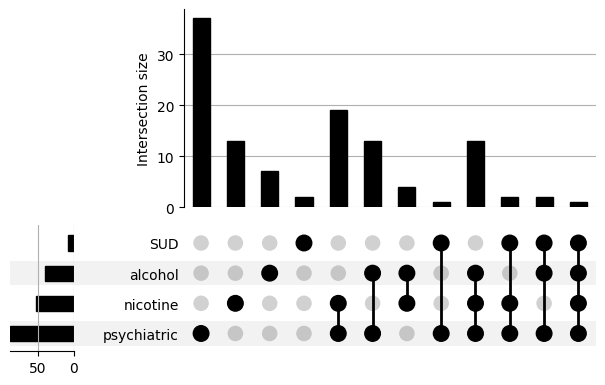

In [90]:
UpSet(gwascat, subset_size='count').plot()
if save_fig:
    plt.savefig('figures/' + 'gwas_catalog_test_upset.svg')

# FUMA Gene to Function - integrate into network

## import datasets

In [35]:
#downloaded from FUMA- server
gtex54=pd.read_csv('input_files/FUMA_gene2func_fdr25_alcoholintake_network/gtex_v8_ts_DEG_annotatedsystem.txt', sep='\t')
gtex_meta=pd.read_csv('input_files/FUMA_gene2func_fdr25_alcoholintake_network/geneTable.txt', sep='\t')
gtex_meta.index=gtex_meta.ensg

In [37]:
gtex_dict=gtex_meta[['symbol']].to_dict

## format gtex 54 tissues output

In [56]:
gtex54_sig=gtex54[gtex54['adjP']<0.05]
twoside=gtex54_sig[gtex54_sig['Category']=='DEG.twoside']['GeneSet']
up=gtex54_sig[gtex54_sig['Category']=='DEG.up']['GeneSet']
down=gtex54_sig[gtex54_sig['Category']=='DEG.down']['GeneSet']
gtex54_sig=gtex54_sig[gtex54_sig['Category']=='DEG.twoside']
gtex54_sig['genes']=gtex54_sig['genes'].str.split(':')
gtex54_sig_exp=gtex54_sig.explode('genes')
gtex54_sig_exp=gtex54_sig_exp.merge(gtex_meta[['symbol']], left_on='genes', right_on='ensg',how='left')

In [45]:
print('list of tissues analyzed:')
set(gtex54_sig_exp['GeneSet'])

list of tissues analyzed:


{'Adrenal_Gland',
 'Bladder',
 'Brain_Amygdala',
 'Brain_Anterior_cingulate_cortex_BA24',
 'Brain_Caudate_basal_ganglia',
 'Brain_Cerebellar_Hemisphere',
 'Brain_Cerebellum',
 'Brain_Cortex',
 'Brain_Frontal_Cortex_BA9',
 'Brain_Hippocampus',
 'Brain_Hypothalamus',
 'Brain_Nucleus_accumbens_basal_ganglia',
 'Brain_Putamen_basal_ganglia',
 'Brain_Spinal_cord_cervical_c-1',
 'Brain_Substantia_nigra',
 'Cells_Cultured_fibroblasts',
 'Colon_Transverse',
 'Esophagus_Mucosa',
 'Heart_Atrial_Appendage',
 'Heart_Left_Ventricle',
 'Kidney_Cortex',
 'Liver',
 'Minor_Salivary_Gland',
 'Muscle_Skeletal',
 'Pancreas',
 'Skin_Not_Sun_Exposed_Suprapubic',
 'Skin_Sun_Exposed_Lower_leg',
 'Small_Intestine_Terminal_Ileum',
 'Stomach',
 'Whole_Blood'}

In [49]:
# group gtex tissues into collapsed table- for adding info to network node descriptions
gtex54_sig_collapse=gtex54_sig_exp[['symbol','GeneSet','adjP']]
gtex54_sig_collapse=gtex54_sig_collapse.groupby('symbol').agg(tuple).applymap(list).reset_index()
gtex54_sig_collapse['N_GeneSet']=gtex54_sig_collapse['GeneSet'].apply(lambda x: len(x))
#make empty columns for all of the tissues set to false
gtex54_sig_collapse[list(range(3,len(twoside)+3))]=False
gtex54_sig_collapse.columns=['symbol','GeneSet','adjP','N_Geneset']+list(twoside)

#assign true/false for each tissue column for whether there is a significant enrichment in each tissue for each gene
for i in twoside:
    for j in range(len(gtex54_sig_collapse)):
        gtex54_sig_collapse[i].iloc[j] = i in gtex54_sig_collapse['GeneSet'][j]

## Plot gene FUMA DEG

In [68]:
twoside_tbl=gtex54[gtex54['Category']=='DEG.twoside']
twoside_tbl=twoside_tbl.sort_values("adjP", ascending=True)
#make a tissue dictionary to define a colour scheme
tiss_col_dict={'neuro':'#785EF0','gastro':'#FFB000','cardiac':'#D41A75', 'urinary':'#FFDF58','epidermal':'#6BABFF','other':'#FF7D2D', 'NS':"#CCCCCC",}
#assign colour to table
twoside_tbl['colour']=twoside_tbl['System'].apply(lambda x: tiss_col_dict.get(x))

In [70]:
plt.rcParams.update({'font.size': 10})

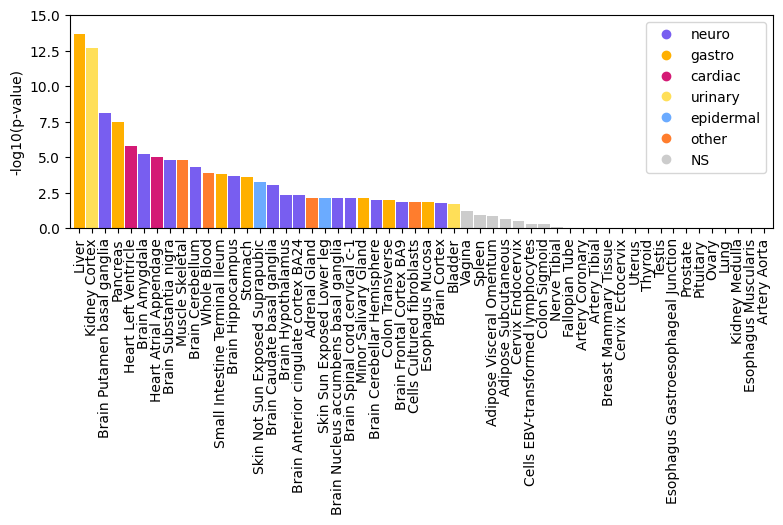

In [71]:
fig=plt.figure(figsize=(7.5,5))
fig=plt.bar(twoside_tbl['GeneSet'].str.replace('_',' '), -np.log10(twoside_tbl['adjP']), width=.9, align='center', color=twoside_tbl['colour'])
fig=plt.xticks(rotation=90)
fig=plt.ylabel('-log10(p-value)')
fig=plt.ylim([0,15])
fig=plt.tight_layout(pad=0)
fig=plt.margins(x=0.005)

# create legend
markers = [plt.Line2D([0,0],[0,0],color=color, marker='o', linestyle='') for color in tiss_col_dict.values()]
plt.legend(markers, tiss_col_dict.keys(), numpoints=1)
if save_fig:
    plt.savefig('figures/' + 'gtex_enrichment_barplot_expanded.svg',bbox_inches='tight')

# make dataframe for adding meta data to network

In [113]:
#make empty dataframe of nodes in ACN
df=pd.DataFrame(nodes)
df.columns=['nodes']
#make columns for whether there are genes in the ACN that have been annotated for alcohol/ at all in GWAS catalog
df['in_gwas_catalog']=df['nodes'].isin(cat['GENE'])
df['alc_val']=df['nodes'].isin(cat_traits_ACN['alc']['GENE'])
#merge in annotation for catagories for gwas catalog
df=df.merge(t, left_on='nodes',right_on='GENE',how='left')
#merge in family names
df=df.merge(families,left_on='nodes',right_on='HGNC Symbol',how='left')
df=df.drop(['GENE'],axis=1)
df.head()

,nodes,in_gwas_catalog,alc_val,ALC_TRAIT,SMOK_TRAIT,SUD_TRAIT,NEUROPSYCH_TRAIT,HGNC Symbol,Approved name,family
0,STAM2,True,False,NaN,{smoking status measurement: smoking initiatio...,NaN,{intelligence: general cognitive ability},NaN,NaN,NaN
1,SH3BP4,True,False,NaN,{unipolar depression: depression in smokers},NaN,{memory performance: cognitive function (delay...,SH3BP4,SH3 domain binding protein 4,NaN
2,OTUD6B,True,False,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,RAD23A,True,False,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,HSP90AA1,True,True,"{nicotine use, generational effect measurement...",{smoking initiation: smoking initiation},NaN,NaN,NaN,NaN,NaN


In [114]:
df=df.merge(gtex54_sig_collapse, left_on='nodes',right_on='symbol',how='left')
df=df.drop(['symbol'],axis=1)
df.head()

,nodes,in_gwas_catalog,alc_val,ALC_TRAIT,SMOK_TRAIT,SUD_TRAIT,NEUROPSYCH_TRAIT,HGNC Symbol,Approved name,family,...,Brain_Nucleus_accumbens_basal_ganglia,Brain_Putamen_basal_ganglia,Brain_Spinal_cord_cervical_c-1,Brain_Substantia_nigra,Adrenal_Gland,Cells_Cultured_fibroblasts,Muscle_Skeletal,Whole_Blood,Bladder,Kidney_Cortex
0,STAM2,True,False,NaN,{smoking status measurement: smoking initiatio...,NaN,{intelligence: general cognitive ability},NaN,NaN,NaN,...,True,True,False,True,False,True,True,True,False,False
1,SH3BP4,True,False,NaN,{unipolar depression: depression in smokers},NaN,{memory performance: cognitive function (delay...,SH3BP4,SH3 domain binding protein 4,NaN,...,True,True,False,True,False,True,True,False,False,False
2,OTUD6B,True,False,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,False,True,False,False,False,False,False,True,False,True
3,RAD23A,True,False,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,HSP90AA1,True,True,"{nicotine use, generational effect measurement...",{smoking initiation: smoking initiation},NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## make dataframe into dictionary and add node attributes to network

In [82]:
#necessary to replace NA to uploade to ndex
df=df.fillna('null')
df = df.astype(str)
#df.index=df['nodes']
df_dict=df.to_dict()
attributes=df.columns
attributes=attributes.drop('nodes')

In [83]:
#add attributes to network
for a in attributes:
    for i in network.nodes:
        network.set_node_attribute(node=i, attribute_name=a, type='string',values=df_dict[a][i])

In [ ]:
if save_file:
    df.to_csv('calculated_values/supplemental_table_5.csv',index=False)

# export network to ndex

In [85]:
#check the attributes added to nodes
network.get_node_attributes(25)

[{'po': 25, 'n': 'HGNC Symbol', 'v': 'SLC5A6'},
 {'po': 25,
  'n': 'z_alcoholintake_FDR_25',
  'v': '2.258363338262249',
  'd': 'double'},
 {'po': 25,
  'n': 'z_GSCAN_DPW_magma',
  'v': '13.762914916228087',
  'd': 'double'},
 {'po': 25, 'n': 'z_comb', 'v': '31.081662474432164', 'd': 'double'},
 {'po': 25, 'n': 'seed_alcoholintake_FDR_25', 'v': 'false', 'd': 'boolean'},
 {'po': 25, 'n': 'seed_GSCAN_DPW_magma', 'v': 'true', 'd': 'boolean'},
 {'po': 25, 'n': 'seed_both', 'v': 'false', 'd': 'boolean'},
 {'po': 25, 'n': 'seed_color_scheme', 'v': '2', 'd': 'integer'},
 {'po': 25, 'n': 'in_gwas_catalog', 'v': 'True', 'd': 'string'},
 {'po': 25, 'n': 'alc_val', 'v': 'False', 'd': 'string'},
 {'po': 25, 'n': 'ALC_TRAIT', 'v': 'null', 'd': 'string'},
 {'po': 25, 'n': 'SMOK_TRAIT', 'v': 'null', 'd': 'string'},
 {'po': 25, 'n': 'SUD_TRAIT', 'v': 'null', 'd': 'string'},
 {'po': 25, 'n': 'NEUROPSYCH_TRAIT', 'v': 'null', 'd': 'string'},
 {'po': 25, 'n': 'HGNC Symbol', 'v': 'SLC5A6', 'd': 'string'},


In [ ]:
network.set_name(network.get_name()+'_annotated')
#use to upload as new newtwork with annotated subscript
if save_file:
    network.upload_to(server='public.ndexbio.org',
                      username=ndex_user,
                      password=ndex_password)

# check seed gene validation in GWAS catalog

## build tables and export

In [120]:
rare_seed_df = pd.DataFrame({'GENE': seed_rare})
rare_seed_df=rare_seed_df.merge(df, left_on='GENE',right_on='HGNC Symbol',how='left')
if save_file:
    rare_seed_df.to_csv("calculated_values/rare_seed_gene_catalog.csv",sep=",",index=False)

In [122]:
common_seed_df= seed_common.merge(df,left_on='GENE_NAME',right_on='HGNC Symbol',how='left')
if save_file:
    common_seed_df.to_csv("calculated_values/common_seed_geneGWAS_catalog.csv",sep=",",index=False)

In [123]:
common_seed_df

,GENE,CHR,START,STOP,NSNPS,NPARAM,N,ZSTAT,P,GENE_NAME,...,Brain_Nucleus_accumbens_basal_ganglia,Brain_Putamen_basal_ganglia,Brain_Spinal_cord_cervical_c-1,Brain_Substantia_nigra,Adrenal_Gland,Cells_Cultured_fibroblasts,Muscle_Skeletal,Whole_Blood,Bladder,Kidney_Cortex
0,79814,1,15561699,15595110,199,19,628831,4.9260,4.195900e-07,AGMAT,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,84301,1,15607458,15671057,215,18,618929,5.5125,1.769100e-08,DDI2,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,6248,1,15649869,15671722,63,10,625701,5.6159,9.774400e-09,RSC1A1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,23207,1,15674267,15744769,299,32,623320,6.6035,2.008100e-11,PLEKHM2,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,127550,1,33296766,33331098,137,27,614472,4.6316,1.814100e-06,A3GALT2,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
289,26291,19,48745559,48768330,115,32,616393,6.1094,5.000000e-10,FGF21,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
290,92675,20,18577912,18773917,1107,41,626041,5.0186,2.602700e-07,DTD1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
291,84532,20,24996230,25068182,267,42,634326,5.0032,2.819800e-07,ACSS1,...,False,False,True,False,True,True,False,True,False,False
292,116448,21,33060144,33082422,63,25,630584,4.6502,1.657900e-06,OLIG1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [108]:
t

,GENE,ALC_TRAIT,SMOK_TRAIT,SUD_TRAIT,NEUROPSYCH_TRAIT
0,A1CF,"{triglyceride measurement, alcohol consumption...",NaN,NaN,{cognitive function measurement: cognitive fun...
1,AADAT,{alcohol consumption measurement: alcohol cons...,NaN,NaN,NaN
2,AATF,{alcohol consumption measurement: drinks per w...,{smoking initiation: smoking initiation},NaN,NaN
3,ABCA1,"{alcohol drinking, high density lipoprotein ch...","{lung carcinoma: lung cancer in ever smokers, ...",NaN,"{alzheimer disease, whole-brain volume: whole-..."
4,ABCA4,{aspartate aminotransferase measurement: aspar...,NaN,NaN,NaN
...,...,...,...,...,...
15483,other genes,NaN,NaN,NaN,"{bipolar disorder, schizophrenia: bipolar diso..."
15484,snoZ13_snr52,NaN,NaN,NaN,"{anxiety measurement: anxiety, unipolar depres..."
15485,snoZ6,NaN,NaN,NaN,"{alzheimer disease, family history of alzheime..."
15486,tcag7.1213,NaN,NaN,NaN,{exploratory eye movement measurement: explora...
